In [1]:
import numpy as np
from galpy.orbit import Orbit
from galpy.potential import MWPotential2014
import astropy.units as u
from astropy.table import Table
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import multiprocessing
from scipy.stats import gaussian_kde,rv_continuous
from scipy.integrate import quad
from scipy.interpolate import interp1d
from astropy.coordinates import SkyCoord
from mw_plot import MWPlot
import matplotlib.animation as animation
from matplotlib.animation import FFMpegWriter

ImportError: No module named mw_plot

In [2]:
print('Success')

Success


In [45]:
%matplotlib notebook

In [46]:
# Defining some global constants which do not change with source
r_lim = 40 #kpc
r0 = 0.01 #kpc

n_iter = 5000         # Number of realizations from source parameters (ra, dec, d, pm, V)
n_cores = 16         # Number of parallel threads

# Orbit integration parameters:
int_time = 10       # Orbit integration time
orbit_pnts = 10000     # Number of orbit points to integrate

#Normalisation constants for density prior
rho_0b = 1.0719
rho_0d = 2.6387
rho_0s = 13.0976
#Parameters for density prior
q = 0.6
gamma = 1.8
rt = 1.9
rm = 6.5
rd = 3.5
rz = 0.41
bs = 7.669
Re = 2.8

### Define source parameters to be used

In [47]:
"""
name = 'Cyg X-1'
w = 0.42              # mas PARALLAX
s = 0.03              # mas PARALLAX ERROR
RA =299.590316        # RA in degrees
DEC =35.201606        # Dec in degrees
pm_ra = -3.88         # Measured proper motion of the source in mas/yr in RA
pm_ra_err = 0.05      # Error on the proper motion of the source in mas/yr in RA
pm_dec = -6.17        # Measured proper motion of the source in mas/yr in Dec
pm_dec_err = 0.05     # Error on proper motion of the source in mas/yr in Dec
V_rad = -5.1          # Radial velocity of the source in km/s
V_rad_err = 0.5       # Error on the radial velocity of the source in km/s

name = '1A 0620-00'
w = 0.64              # mas PARALLAX
s = 0.16              # mas PARALLAX ERROR
RA = 95.685592        # RA in degrees
DEC = -0.345636       # Dec in degrees
pm_ra = -0.09         # Measured proper motion of the source in mas/yr in RA
pm_ra_err = 0.25      # Error on the proper motion of the source in mas/yr in RA
pm_dec = -5.20        # Measured proper motion of the source in mas/yr in Dec
pm_dec_err = 0.30     # Error on proper motion of the source in mas/yr in Dec
V_rad = 8.5          # Radial velocity of the source in km/s
V_rad_err = 1.8       # Error on the radial velocity of the source in km/s

name = 'GR01655-40'
w = 0.27              # mas PARALLAX Gaia DR2 
s = 0.08              # mas PARALLAX ERROR
RA = 253.500583       # RA in degrees
DEC = -39.845806      # Dec in degrees
pm_ra = -4.20         # Gaia DR2, proper motion of the source in mas/yr in RA
pm_ra_err = 0.13      # Error on the proper motion of the source in mas/yr in RA
pm_dec = -7.44        # Gaia DR2, proper motion of the source in mas/yr in Dec
pm_dec_err = 0.09     # Error on proper motion of the source in mas/yr in Dec
V_rad = -142          # Shahbaz et al 1999, Radial velocity of the source in km/s 
V_rad_err = 1.5       # Error on the radial velocity of the source in km/s

name = 'GS1124-684'
#All parameters taken from GAIA DR2
w = 0.61              # mas PARALLAX
s = 0.34              # mas PARALLAX ERROR
RA = 171.610811       # RA in degrees
DEC = -68.675802      # Dec in degrees
pm_ra = -2.44         # Measured proper motion of the source in mas/yr in RA
pm_ra_err = 0.61      # Error on the proper motion of the source in mas/yr in RA
pm_dec = -0.71        # Measured proper motion of the source in mas/yr in Dec
pm_dec_err = 0.46     # Error on proper motion of the source in mas/yr in Dec
V_rad = 16            # Radial velocity of the source in km/s
V_rad_err = 5         # Error on the radial velocity of the source in km/s


name = 'XTEJ1118+480'
#We will use the distance estimate and not the Gaia DR2 parallax because of large error in parallax
w = 0.30              # mas PARALLAX
s = 0.40              # mas PARALLAX ERROR
RA = 169.544968       # RA in degrees
DEC =  48.036755      # Dec in degrees
pm_ra = -17.57        # Gaia DR2, proper motion of the source in mas/yr in RA
pm_ra_err = 0.34      # Error on the proper motion of the source in mas/yr in RA
pm_dec = -6.98        # Gaia DR2, proper motion of the source in mas/yr in Dec
pm_dec_err = 0.43     # Error on proper motion of the source in mas/yr in Dec
V_rad = 2.7           # Hernandez et al 2008, Radial velocity of the source in km/s 
V_rad_err = 1.1       # Error on the radial velocity of the source in km/s
d = 1.72              # Distance from inclination angle, Gelino et al. 2006, in kpc
d_err = 0.1

name = 'MAXIJ1836-194'
RA =  278.931000     # RA in degrees
DEC =   -19.319578   # Dec in degrees
pm_ra = -2.3         # Russell et al 2014, proper motion of the source in mas/yr in RA
pm_ra_err = 0.6      # Error on the proper motion of the source in mas/yr in RA
pm_dec = -6.1        # Russell et al 2014, proper motion of the source in mas/yr in Dec
pm_dec_err = 1.0     # Error on proper motion of the source in mas/yr in Dec
V_rad = 61           # Russell et al 2014, Radial velocity of the source in km/s 
V_rad_err = 15       # Error on the radial velocity of the source in km/s
d_low = 4            # Distance from accretion disk rate, Russell 2014 MNRAS 439, in kpc
d_high = 10

name = 'GRS1716-249_50kms'
#This system does not have parallax measurement, use a uniform distribution
d = 2.4                 # della Valle et al 1994, P.Jonker does not trust this distance
d_err = 0.4
RA = 259.903875         # RA in degrees
DEC = -25.017619        # Dec in degrees
pm_ra = -1.70           # Measured proper motion of the source in mas/yr in RA
pm_ra_err = 1.25        # Error on the proper motion of the source in mas/yr in RA
pm_dec = -2.48          # Measured proper motion of the source in mas/yr in Dec
pm_dec_err = 0.75       # Error on proper motion of the source in mas/yr in Dec
V_low = -50            # Radial velocity of the source in km/s
V_high = 50            # Error on the radial velocity of the source in km/s
V_rad = 0              # Centre of Gaussian
V_rad_err = 50         # 1sigma for Gaussian distribution in km/s


name = '4U1543-475'
d = 7.5               #Distance from Orsoz et al. 2004 
d_err = 1
RA =  236.784486      # RA in degrees
DEC =  -47.669524     # Dec in degrees
pm_ra = -7.41         # Measured proper motion of the source in mas/yr in RA
pm_ra_err = 0.14      # Error on the proper motion of the source in mas/yr in RA
pm_dec = -5.33        # Measured proper motion of the source in mas/yr in Dec
pm_dec_err = 0.10     # Error on proper motion of the source in mas/yr in Dec
V_rad = -87           # Radial velocity of the source in km/s
V_rad_err = 3         # Error on the radial velocity of the source in km/s


name = 'V404Cyg'
w = 0.418             # mas PARALLAX Miller-Jones et al. 2009
s = 0.024             # mas PARALLAX ERROR
RA = 306.015917       # RA in degrees
DEC = 33.867194       # Dec in degrees
pm_ra = -4.99         # Miller-Jones et al. 2009, proper motion of the source in mas/yr in RA
pm_ra_err = 0.19      # Error on the proper motion of the source in mas/yr in RA
pm_dec = -7.76        # Miller-Jones et al. 2009, proper motion of the source in mas/yr in Dec
pm_dec_err = 0.21     # Error on proper motion of the source in mas/yr in Dec
V_rad = -0.4           # Radial velocity of the source in km/s Casares and Charles 1994
V_rad_err = 2.2         # Error on the radial velocity of the source in km/s

name = 'ARASH'
RA =  232.07320959434 # RA in degrees
DEC = -58.58718010029 # Dec in degrees
pm_ra = -2.333        # Proper motion of the source in mas/yr in RA
pm_ra_err = 0.045     # Error on the proper motion of the source in mas/yr in RA
pm_dec = -1.970       # Proper motion of the source in mas/yr in Dec
pm_dec_err = 0.051    # Error on proper motion of the source in mas/yr in Dec
V_rad = 55            # Radial velocity of the source in km/s 
V_rad_err = 20        # Error on the radial velocity of the source in km/s
d = 2.3               # Distance in kpc
d_err = 0.2 



name = 'GRS1009-45'
#All parameters taken from GAIA DR2
w = 0.274              # mas PARALLAX
s = 0.114              # mas PARALLAX ERROR
RA =  153.401678581    # RA in degrees
DEC =  -45.0756991     # Dec in degrees
pm_ra = -5.422447      # Measured proper motion of the source in mas/yr in RA
pm_ra_err = 0.169153   # Error on the proper motion of the source in mas/yr in RA
pm_dec = 2.526292      # Measured proper motion of the source in mas/yr in Dec
pm_dec_err = 0.177519  # Error on proper motion of the source in mas/yr in Dec
V_rad = 4.6            # Radial velocity of the source in km/s
V_rad_err = 6.2        # Error on the radial velocity of the source in km/s


name = 'GS1354-64_sysvelguess'
#All parameters taken from GAIA DR2
w = 1.83              # mas PARALLAX
s = 0.58              # mas PARALLAX ERROR
RA = 209.540417       # RA in degrees
DEC = -64.734944      # Dec in degrees
pm_ra = -9.38         # Measured proper motion of the source in mas/yr in RA
pm_ra_err = 2.22      # Error on the proper motion of the source in mas/yr in RA
pm_dec = -5.70        # Measured proper motion of the source in mas/yr in Dec
pm_dec_err = 2.26     # Error on proper motion of the source in mas/yr in Dec
#V_rad = 103           # Radial velocity of the source in km/s
#V_rad_err = 4         # Error on the radial velocity of the source in km/s
V_rad = 0           # Radial velocity of the source in km/s, to use a gaussian centred on zero
V_rad_err = 100         # Error on the radial velocity of the source in km/


name = 'MAXIJ1820+070_200kms'
#All parameters taken from GAIA DR2
w = 0.31              # mas PARALLAX
s = 0.11              # mas PARALLAX ERROR
RA =  275.091417      # RA in degrees
DEC =  7.185331     # Dec in degrees
pm_ra = -3.14         # Measured proper motion of the source in mas/yr in RA
pm_ra_err = 0.19      # Error on the proper motion of the source in mas/yr in RA
pm_dec = -5.90        # Measured proper motion of the source in mas/yr in Dec
pm_dec_err = 0.22     # Error on proper motion of the source in mas/yr in Dec
V_rad = 200         # Radial velocity of the source in km/s
V_rad_err = 50       # Error on the radial velocity of the source in km/s


name = 'VLAJ2130_50kms'
w = 0.45              # mas PARALLAX #Kirsten et al.
s = 0.08              # mas PARALLAX ERROR
RA =  322.5083      # RA in degrees
DEC =  12.1511     # Dec in degrees
pm_ra = -0.07         # Measured proper motion of the source in mas/yr in RA
pm_ra_err = 0.13      # Error on the proper motion of the source in mas/yr in RA
pm_dec = -1.26        # Measured proper motion of the source in mas/yr in Dec
pm_dec_err = 0.29     # Error on proper motion of the source in mas/yr in Dec
V_rad = 50         # Radial velocity of the source in km/s
V_rad_err = 50       # Error on the radial velocity of the source in km/s


name = 'SAXJ1819-2525'
#All parameters taken from GAIA DR2
w = 0.15              # mas PARALLAX
s = 0.04              # mas PARALLAX ERROR
RA =  274.840143      # RA in degrees
DEC =  -25.407180     # Dec in degrees
pm_ra = -0.73         # Measured proper motion of the source in mas/yr in RA
pm_ra_err = 0.07      # Error on the proper motion of the source in mas/yr in RA
pm_dec = -0.42        # Measured proper motion of the source in mas/yr in Dec
pm_dec_err = 0.06     # Error on proper motion of the source in mas/yr in Dec
V_rad = 107.4         # Radial velocity of the source in km/s
V_rad_err = 2.9       # Error on the radial velocity of the source in km/s

name = 'tMSP_Gaussian'
w = 0.598             # mas PARALLAX
s = 0.269              # mas PARALLAX ERROR
RA =  236.1625      # RA in degrees
DEC =  -11.4678     # Dec in degrees
pm_ra = 20.1         # Measured proper motion of the source in mas/yr in RA
pm_ra_err = 0.4      # Error on the proper motion of the source in mas/yr in RA
pm_dec = -12.3        # Measured proper motion of the source in mas/yr in Dec
pm_dec_err = 0.4     # Error on proper motion of the source in mas/yr in Dec
V_rad = 143.9         # Radial velocity of the source in km/s
V_rad_err = 1.2       # Error on the radial velocity of the source in km/s
d = 3.8
d_err = 0.7 


name = 'GX 339-4'
#This system does not have parallax measurement, use a uniform distribution
d_low = 5
d_high = 13
d = 9                 # Heida et al. 2017 
RA = 255.705754       # RA in degrees
DEC = -48.789768      # Dec in degrees
pm_ra = -3.95         # Measured proper motion of the source in mas/yr in RA
pm_ra_err = 0.07      # Error on the proper motion of the source in mas/yr in RA
pm_dec = -4.71        # Measured proper motion of the source in mas/yr in Dec
pm_dec_err = 0.06     # Error on proper motion of the source in mas/yr in Dec
V_rad = 26            # Radial velocity of the source in km/s
V_rad_err = 2         # Error on the radial velocity of the source in km/s

name = 'GRS1915+105'
w = 0.12              # mas PARALLAX Reid et al. 2014. This is actually the parallax of G045.07+0.13 maser 
s = 0.009             # mas PARALLAX ERROR
#We shall use the distance estimate in the above mentioned paper and not the parallax for our natal kick distribution
RA =  288.798122      # RA in degrees
DEC = 10.945766       # Dec in degrees
pm_ra = -2.86         # Dhawan et al. 2007, proper motion of the source in mas/yr in RA
pm_ra_err = 0.07      # Error on the proper motion of the source in mas/yr in RA
pm_dec = -6.20        # Dhawan et al. 2007, proper motion of the source in mas/yr in Dec
pm_dec_err = 0.09     # Error on proper motion of the source in mas/yr in Dec
V_rad = 11            # Steeghs et al 2013, Radial velocity of the source in km/s 
V_rad_err = 4.5       # Error on the radial velocity of the source in km/s
d = 8.6
d_err = 2


name = 'GRS1716-249_200kms'
#This system does not have parallax measurement, use a uniform distribution
d = 2.4                 # della Valle et al 1994, P.Jonker does not trust this distance
d_err = 0.4
RA = 259.903875         # RA in degrees
DEC = -25.017619        # Dec in degrees
pm_ra = -1.70           # Measured proper motion of the source in mas/yr in RA
pm_ra_err = 1.25        # Error on the proper motion of the source in mas/yr in RA
pm_dec = -2.48          # Measured proper motion of the source in mas/yr in Dec
pm_dec_err = 0.75       # Error on proper motion of the source in mas/yr in Dec
V_low = -50            # Radial velocity of the source in km/s
V_high = 50            # Error on the radial velocity of the source in km/s
V_rad = 50              # Centre of Gaussian
V_rad_err = 100         # 1sigma for Gaussian distribution in km/s
"""

name = 'SwiftJ1753'
w = -0.01             # mas PARALLAX
s = 0.13              # mas PARALLAX ERROR
RA = 268.367874       # RA in degrees
DEC = -1.451738       # Dec in degrees
pm_ra = 0.9           # Measured proper motion of the source in mas/yr in RA
pm_ra_err = 0.06      # Error on the proper motion of the source in mas/yr in RA
pm_dec = -3.64        # Measured proper motion of the source in mas/yr in Dec
pm_dec_err = 0.06     # Error on proper motion of the source in mas/yr in Dec
V_rad = 130           # Radial velocity of the source in km/s
V_rad_err = 10         # Error on the radial velocity of the source in km/s


c_icrs = SkyCoord(ra=RA*u.degree, dec=DEC*u.degree, frame='icrs') # RA and DEC in degrees of the source
l = c_icrs.galactic.l.deg                                         # Converting to Galactic longitude 
b = c_icrs.galactic.b.deg                                         # Converting to Galactic latitude

### Simulation function:

Simply an integrated Galpy orbit, where passes through the plane are identified in this orbit and peculiar velocity during every pass is estimated.

In [48]:
def pass_v(ra,dec,d,pm_ra,pm_dec,V, time, numpoints):
    """
    Function to estimate system velocity everytime it passes through the galactic plane.
    
    ra,dec,d,pm_ra,pm_dec,V are source orbit parameters for Galpy
    
    time is the age to integrate (Gyr)
        
    numpoints is the number of points in the orbit to integrate.
    
    """
    o = Orbit([ra*u.deg,dec*u.deg,d*u.kpc,pm_ra*u.mas/u.yr,pm_dec*u.mas/u.yr,V*u.km/u.s],radec=True)
    lp= MWPotential2014
    ts= np.linspace(0,time,numpoints)*u.Gyr
    o.integrate(ts,lp)
    
    pass_t_array = ts[np.where(np.sign(o.z(ts)[:-1])-np.sign(o.z(ts)[1:])!=0)[0]]
    results = []
    for pass_t in pass_t_array:
        o2 = Orbit(vxvv=[o.R(pass_t)/8.0,0.,1.,0.,0.,o.phi(pass_t)],ro=8.,vo=220.)
        #results.append(np.sqrt((o.U(pass_t)-o2.U(0)+11.1)**2 + (o.V(pass_t)-o2.V(0)+12.24)**2 + (o.W(pass_t)-o2.W(0)+7.25)**2))
        results.append(np.sqrt((o.U(pass_t)-o2.U(0))**2 + (o.V(pass_t)-o2.V(0))**2 + (o.W(pass_t)-o2.W(0))**2))
    
    return results

In [49]:
def peculiar(ra,dec,d,pm_ra,pm_dec,V):
    """
    Function to estimate system peculiar velocity distribution as a function of distance.
    
    ra,dec,d,pm_ra,pm_dec,V are source orbit parameters for Galpy
            
    numpoints is the number of points in the orbit to integrate.
    
    """
    o = Orbit([ra*u.deg,dec*u.deg,d*u.kpc,pm_ra*u.mas/u.yr,pm_dec*u.mas/u.yr,V*u.km/u.s],radec=True)
    o2 = Orbit(vxvv=[o.R(0.)/8.0,0.,1.,0.,0.,o.phi(0.)],ro=8.,vo=220.)
    current_vel = np.sqrt((o.U(0.)-o2.U(0)+11.1)**2 + (o.V(0.)-o2.V(0)+12.24)**2 + (o.W(0.)-o2.W(0)+7.25)**2)
    return current_vel

### Distance estimator:
Using the recipe mentioned in Poshak et al. 2018

Defining all the functions

In [50]:
""" Milky Way Density prior as described by Poshak et al. 2018, 
    taking densities and formulating constants from Grimm et al. 2002
    
    Calculation of r and z based on relations in Igoshev et al. 2016 
    Calculation of R is based on relation used by tools_coordatnfcsiro.au 
    which converts Heliocentric to Galactocentric distance.
    
    z is height of the source above the Galactic plane in kpc
    r is the distance of the source in the Galactic plane from the Galactic centre
    R is the distance from the Galactic cent
    re in spherical coordinates
    x is the assumed distance in kpc
    l and b are Galactic latitude and longitude
    """
def bulge(r,z):
    k = (r**2 + ((z**2)/(q**2)))
    return rho_0b*((np.sqrt(k))**(-gamma))*np.exp(-k/(rt**2))
def disk(r,z):
    return rho_0d*(np.exp(-(rm/rd)-(r/rd)-(np.abs(z)/rz)))
def sphere(R):
    return rho_0s*(np.exp(-bs*((R/Re)**(1.0/4)))/((R/Re)**(7.0/8.0)))

def new_prior(x,l,b,r_lim):
    if x > 0 and x <= r_lim:
        z = x*np.sin(np.radians(b))
        R0 = 8 #Distance of earth from the Galactic centre
        r = np.sqrt(R0**2 + ((x*np.cos(np.radians(b)))**2) - 2*x*R0*np.cos(np.radians(b))*np.cos(np.radians(l)))
        R = np.sqrt(R0**2 + (x**2) - 2*x*R0*np.cos(np.radians(b))*np.cos(np.radians(l)))
        rho_b = bulge(r,z)
        rho_d = disk(r,z)
        rho_s = sphere(R)
        return (rho_b+rho_d+rho_s)*((x*1e3)**2)
    else:
        return 0
    
def posterior(x,w,s,r_lim):
    return new_prior(x,l,b,r_lim)*likelihood(x,w,s)

"""LIKELIHOOD
"""
def likelihood(x,w,s):
    """Return the likelihood
    
    ===========
    Parameters:
    ===========
        **x**
        : number
            Real distance in kpc units.
        **w**
        : number
            Observed parallax in mas units.
        **s** 
        : number
            Parallax error in mas units.
    
    ========
    Returns:
    ========
        **number**
            Returns the likelihood.
    """
    
    return 1/(np.sqrt(2*np.pi)*s)*np.exp(-1/(2*s**2)*(w-1/x)**2)

def normalization(f,par1,w,s,p,r_mode,par2): 
    """Returns the normalization factor of the function f.

    Computes the normalization factor as the summation of the percentile of r_mode plus the integration of the function from r_mode to par2 using the scipy.integrate.quad function. This way numerical errors in the integrration of thin distributions are avoided.
    
    ===========
    Parameters:
    ===========
       **f**
       : function
           Probability distribution function. 
       **par1**
       : number
           Parameter of the function f in kpc.    
       **w**
       : number
           Parameter of the function f in mas.    
       **s**
       : number
           Parameter of the function f in mas.    
       **p**
       : number
           Unnormalized percentile of r_mode.    
       **r_mode**
       : number
           Distance in kpc.      
       **par_2**
       : number
           Superior bound of the integration in kpc.
    ========
    Returns:
    ========
        **number**
            Normalization factor.
   """
    
    N = quad(f, r_mode, par2, args=(w, s, par1),epsrel = 1e-11, epsabs = 1e-11) # We integrate the required posterior from the mode to infinity (par2)
    
    N = N[0] + p # p is the percentile corresponding to the mode, i.e. the integration of the PDF from r0 to r_mode
    
    return N


def percentiles(f,r0,r_mode,w,s,par): # Given a distance (i.e. r_mode), it integrates the PDF from r0 to the given distance and returns the unnormalized percentile
    """Returns the percentile corresponding to a given distance r_mode.
    
    This function integrates the function f with parameters w and s from r0 to r_mode using the scipy.integrate.quad function.
    
    ===========
    Parameters:
    ===========    
        **f** 
        : function
            Probability distribution function.
        **r0**
        : number
            Inferior bound in the integration.
        **r_mode**
        : number
            Superio bound in the integration.
        **w** 
        : number
            Parameter of f. 
        **s**
        : number
            Parameter of f.
    ========
    Returns:
    ========
        **number**
            Unnormalized percentile of r_mode.
    """
    p = quad(f,r0,r_mode,args=(w,s,par),epsrel = 1e-12, epsabs = 1e-12)
    return p[0]

### Unnormalized posterior

<IPython.core.display.Javascript object>


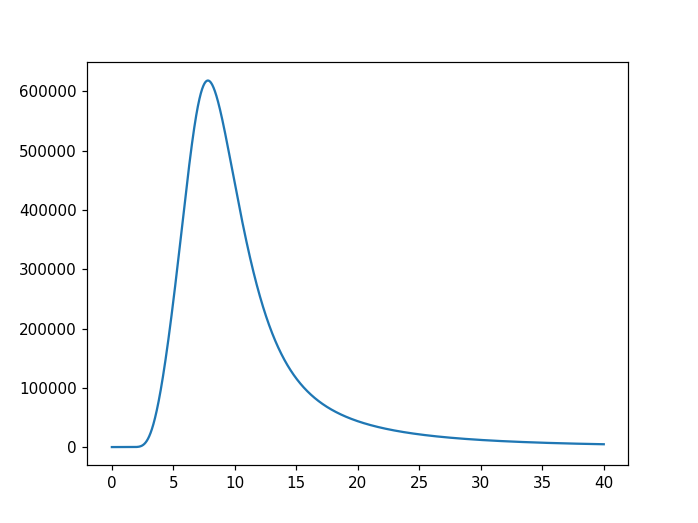

7.818000000000001


In [51]:
x = np.arange(r0,r_lim,r_lim/n_iter)
y1 = [posterior(i,w,s,r_lim) for i in x]
r_mode=x[y1.index(max(y1))]
plt.plot(x,y1)
print(r_mode)
plt.savefig(str(name)+'posterior.png')

### To get an analytical form of the posterior distribution:

In [52]:
p = percentiles(posterior, r0, r_mode, w, s,r_lim)  # Computing the percentile that corresponds to the mode of the PDF
n = normalization(posterior, r_lim, w, s, p, r_mode,r_lim)  # Computing the normalization constant of the PDF
x = np.arange(r0,r_lim,r_lim/n_iter)
y2 = [posterior(i,w,s,r_lim)/n for i in x]
testf = interp1d(x,y2)

In [53]:
class custom_dist_analytical(rv_continuous):
    def _pdf(self, xx):
        return testf(xx)

np.random.seed(124)

### The following kernel constructs arrays of the distributions to be used

In [54]:
# Source parameters:
src_ra = np.random.normal(RA,0, n_iter)
src_dec = np.random.normal(DEC,0,n_iter)
src_d = custom_dist_analytical(a=r0,b=r_lim).rvs(size=n_iter) # Drawing random numbers from MW posterior 
#src_d = np.random.uniform(d_low,d_high,n_iter) # Uniform distance distribution in the case of no parallax measurement
#src_d = np.random.normal(d,d_err,n_iter) #Gaussian distance distribution in case of measured distance in literature
src_pm_ra = np.random.normal(pm_ra,pm_ra_err,n_iter)
src_pm_dec = np.random.normal(pm_dec,pm_dec_err,n_iter)
src_V = np.random.normal(V_rad,V_rad_err,n_iter) #Gaussian radial velocity distribution
#src_V = np.random.uniform(V_low,V_high,n_iter) #Uniform radial velocity distribution in case of unknown value

/home/pikky/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)

/home/pikky/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)



### Running the simulation in parallel:

In [55]:
#To determine the natal kick distribution
v_dist = Parallel(n_jobs=n_cores,verbose=5)(delayed(pass_v)(src_ra[i],src_dec[i],src_d[i],src_pm_ra[i],src_pm_dec[i],src_V[i],int_time,orbit_pnts) for i in range(n_iter))
total_dist = np.concatenate(v_dist[:])

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  40 tasks      | elapsed:   13.8s
[Parallel(n_jobs=16)]: Done 130 tasks      | elapsed:   32.8s
[Parallel(n_jobs=16)]: Done 256 tasks      | elapsed:   58.8s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:  1.6min
[Parallel(n_jobs=16)]: Done 616 tasks      | elapsed:  2.3min
[Parallel(n_jobs=16)]: Done 850 tasks      | elapsed:  3.2min
[Parallel(n_jobs=16)]: Done 1120 tasks      | elapsed:  4.3min
[Parallel(n_jobs=16)]: Done 1426 tasks      | elapsed:  5.4min
[Parallel(n_jobs=16)]: Done 1768 tasks      | elapsed:  6.7min
[Parallel(n_jobs=16)]: Done 2146 tasks      | elapsed:  8.1min
[Parallel(n_jobs=16)]: Done 2560 tasks      | elapsed:  9.7min
[Parallel(n_jobs=16)]: Done 3010 tasks      | elapsed: 11.5min
[Parallel(n_jobs=16)]: Done 3496 tasks      | elapsed: 13.3min
[Parallel(n_jobs=16)]: Done 4018 tasks      | elapsed: 15.3min
[Parallel(n_jobs=16)]: Done 4576 tasks      | e

In [56]:
#To determine the peculiar velocity dustribution
v_c = Parallel(n_jobs=n_cores,verbose=5)(delayed(peculiar)(src_ra[i],src_dec[i],src_d[i],src_pm_ra[i],src_pm_dec[i],src_V[i]) for i in range(n_iter))

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done 128 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done 1208 tasks      | elapsed:    2.9s
[Parallel(n_jobs=16)]: Done 2720 tasks      | elapsed:    6.1s
[Parallel(n_jobs=16)]: Done 5000 out of 5000 | elapsed:   10.8s finished


In [57]:
#Save the distributions in text files in case they have to be used later
np.savetxt(str(name)+'_natalkicks_dist.txt',np.transpose(total_dist),delimiter=' ')
np.savetxt(str(name)+'_distance_dist.txt',np.transpose(src_d),delimiter=' ')

### Plots:

#### 1. Natal kick distribution:

188.88618502700274 117.13514300119519 310.8546255176737


<IPython.core.display.Javascript object>


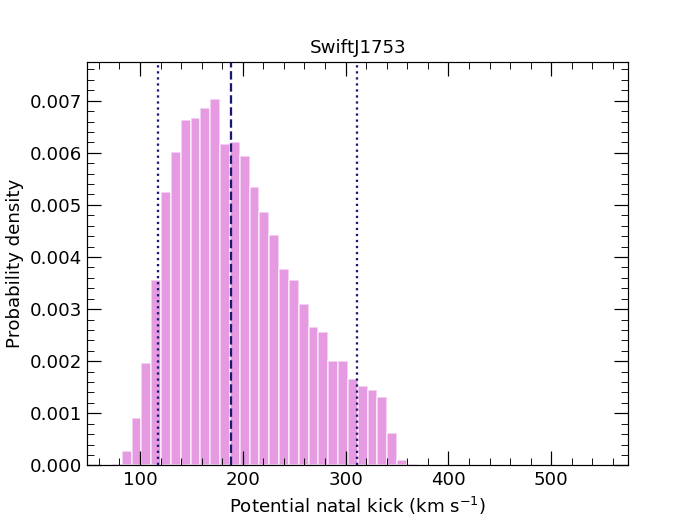

In [59]:
median = np.percentile(total_dist,50)
low_lim = np.percentile(total_dist,5)
high_lim = np.percentile(total_dist,95)
print(median,low_lim,high_lim)
#print('V_peculiar (-/+95%) = ',round(median,2),'( -',round(low_lim,2),'/ +',round(high_lim,2),') km/s')
plt.title(str(name))
histplot = plt.hist(total_dist,bins=50,color='orchid',edgecolor='w',density=True,alpha=0.7)
plt.vlines([low_lim,high_lim],0,max(histplot[0])*1.1,linestyles=':',colors='midnightblue')
plt.vlines(median,0,max(histplot[0])*1.1,linestyles='--',colors='midnightblue')
#plt.vlines(mode,0,max(histplot[0])*1.1,linestyles='--',colors='green')
plt.ylim(0,max(histplot[0])*1.1)
#plt.xlim(0,2000)
plt.ylabel('Probability density', fontsize=12)
plt.xlabel('Potential natal kick (km s$^{-1}$)', fontsize=12)
plt.minorticks_on()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='major', length=9)
plt.tick_params(axis='both', which='minor', length=4.5)
plt.tick_params(axis='both', which='both',direction='in',right=True,top=True)
plt.savefig(str(name)+'_natalkick_dist.png')

#### 2. Distance distribution:

In [ ]:
median = np.percentile(src_d,50)
#mode = np.max(src_d)
low_lim = np.percentile(src_d,5)
high_lim = np.percentile(src_d,95)
print(median,low_lim,high_lim)
histplot = plt.hist(src_d,bins=60,color='teal',edgecolor='w',density=True,alpha=0.7)
#plt.vlines([low_lim,high_lim],0,max(histplot[0])*1.1,linestyles=':',colors='midnightblue')
plt.vlines(median,0,max(histplot[0])*1.1,linestyles=':',colors='midnightblue')
plt.vlines(r_mode,0,max(histplot[0])*1.1,linestyles='--',colors='black')
plt.ylim(0,max(histplot[0])*1.1)
plt.ylabel('Probability density', fontsize=12)
plt.xlabel('Distance (kpc)', fontsize=12)
#plt.xlim(0,50)
plt.title(str(name))
plt.minorticks_on()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='major', length=9)
plt.tick_params(axis='both', which='minor', length=4.5)
plt.tick_params(axis='both', which='both',direction='in',right=True,top=True)
plt.savefig(str(name)+'_distance_dist.png')

In [ ]:
histplot = plt.hist(src_V,bins=50,color='orange',edgecolor='w',density=True,alpha=0.7)
plt.ylim(0,max(histplot[0])*1.1)
plt.ylabel('Probability density', fontsize=12)
plt.xlabel('Radial velocity (km/s)', fontsize=12)
#plt.xlim(268.36,268.4)
plt.title(str(name))
#plt.minorticks_on()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='major', length=9)
plt.tick_params(axis='both', which='minor', length=4.5)
plt.tick_params(axis='both', which='both',direction='in',right=True,top=True)
plt.savefig(str(name)+'_Vrad_dist.png')

#### 3. Posterior distribution:

In [ ]:
plt.plot(x,testf(x))
plt.ylabel('Probability density', fontsize=12)
plt.xlabel('Distance (kpc)', fontsize=12)
plt.savefig(str(name)+'_posterior_dist.png')

#### 4. Peculiar velocity distribution:

203.15869601754073 76.17769607046499 355.14744429109135


<IPython.core.display.Javascript object>


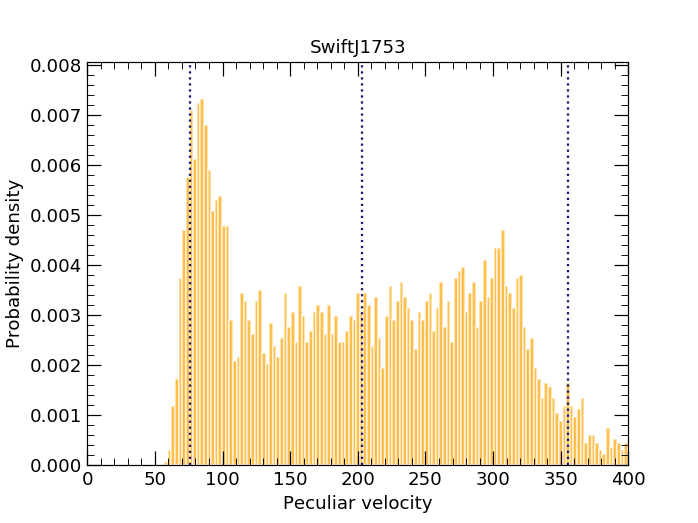

In [60]:
median = np.percentile(v_c,50)
low_lim = np.percentile(v_c,5)
high_lim = np.percentile(v_c,95)
print(median,low_lim,high_lim)
histplot = plt.hist(v_c,bins=180,color='orange',edgecolor='w',density=True,alpha=0.7)
plt.vlines([low_lim,high_lim],0,max(histplot[0])*1.1,linestyles=':',colors='midnightblue')
plt.vlines(median,0,max(histplot[0])*1.1,linestyles=':',colors='midnightblue')
plt.ylim(0,max(histplot[0])*1.1)
plt.ylabel('Probability density', fontsize=12)
plt.xlabel('Peculiar velocity', fontsize=12)
plt.xlim(0,400)
plt.title(str(name))
plt.minorticks_on()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='major', length=9)
plt.tick_params(axis='both', which='minor', length=4.5)
plt.tick_params(axis='both', which='both',direction='in',right=True,top=True)
plt.savefig(str(name)+'_peculiar_velocity.png')

#### Finding mode if asymmetric distribution

In [ ]:
prob = histplot[0]
bins = np.array(histplot[1])
prob==np.max(prob)
mode=bins[np.where(prob ==max(prob))]
print(mode)

#### 5. Sample orbits

<IPython.core.display.Javascript object>


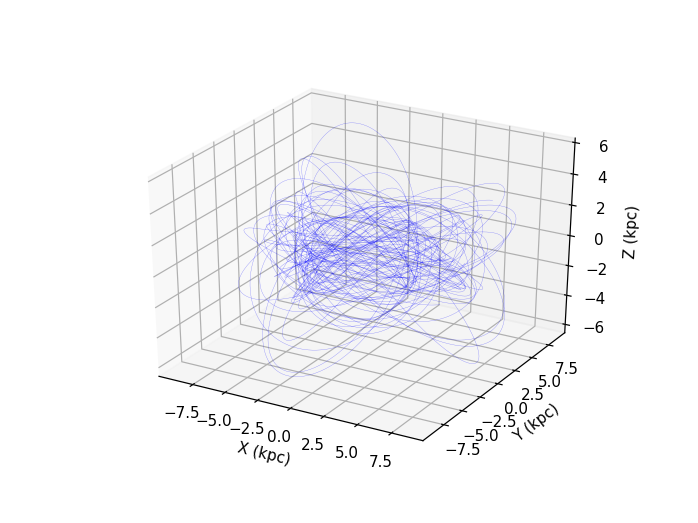

In [61]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_xlabel('X (kpc)')
ax.set_ylabel('Y (kpc)')
ax.set_zlabel('Z (kpc)');
#ax.set_xlim(-10,10)
#ax.set_ylim(-10,10)
#ax.set_zlim(-10,10)
for i in range(20):
    samp_o = Orbit([src_ra[i]*u.deg,src_dec[i]*u.deg,src_d[i]*u.kpc,src_pm_ra[i]*u.mas/u.yr,src_pm_dec[i]*u.mas/u.yr,src_V[i]*u.km/u.s],radec=True)
    lp= MWPotential2014
    ts= np.linspace(0,1.0,10000)*u.Gyr
    samp_o.integrate(ts,lp)
    if src_d[i]<10:
        ax.plot(samp_o.x(ts),samp_o.y(ts),samp_o.z(ts),c='b',linewidth=0.2,alpha=0.5)
plt.savefig(str(name)+'3d_orbits.png')

### To check z max variation with distance:

<IPython.core.display.Javascript object>


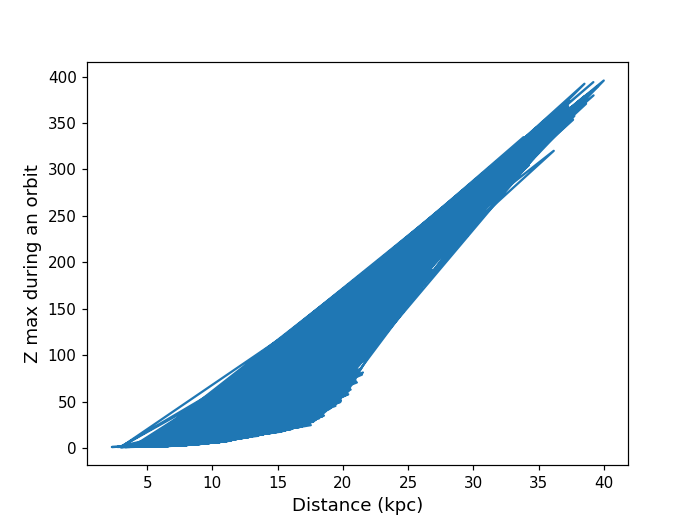

In [71]:
z = []
r = []
for i in range (0,len(src_d)):
    orbits_z = Orbit([src_ra[i]*u.deg,src_dec[i]*u.deg,src_d[i]*u.kpc,src_pm_ra[i]*u.mas/u.yr,src_pm_dec[i]*u.mas/u.yr,src_V[i]*u.km/u.s],radec=True)
    lp= MWPotential2014
    ts= np.linspace(0,1.0,500)*u.Gyr
    orbits_z.integrate(ts,lp)
    z.append(orbits_z.zmax())
    r.append(src_d[i])
np.savetxt(str(name)+'_zmax_dist.txt',np.transpose(z),delimiter=' ')
plt.plot(r,z)
plt.ylabel('Z max during an orbit', fontsize=12)
plt.xlabel('Distance (kpc)', fontsize=12)
plt.savefig(str(name)+'zmax_and_dist.png')

4.83129284389123 1.7001204610214375 110.94176706293835


<IPython.core.display.Javascript object>


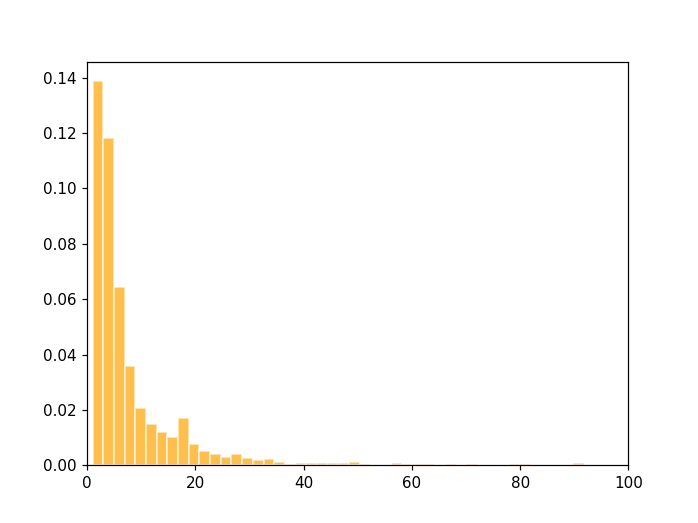

(0, 100)

In [72]:
# Plotting zmax histogram
median = np.percentile(z,50)
low_lim = np.percentile(z,5)
high_lim = np.percentile(z,95)
print(median,low_lim,high_lim)
plt.hist(z,bins=200,color='orange',edgecolor='w',density=True,alpha=0.7)
plt.xlim(0,100)

#### Plotting current z for 5000 instances

In [78]:
z = []
r = []
ts= np.linspace(0,1.0,500)*u.Gyr
lp= MWPotential2014
for i in range (0,len(src_d)):
    orbits_z = Orbit([src_ra[i]*u.deg,src_dec[i]*u.deg,src_d[i]*u.kpc,src_pm_ra[i]*u.mas/u.yr,src_pm_dec[i]*u.mas/u.yr,src_V[i]*u.km/u.s],radec=True)
    z.append(orbits_z.z(0.))
    r.append(src_d[i])
np.savetxt(str(name)+'_z_dist.txt',np.transpose(z),delimiter=' ')

1.907055859205648 1.0697050044924865 4.563691615829983


<IPython.core.display.Javascript object>


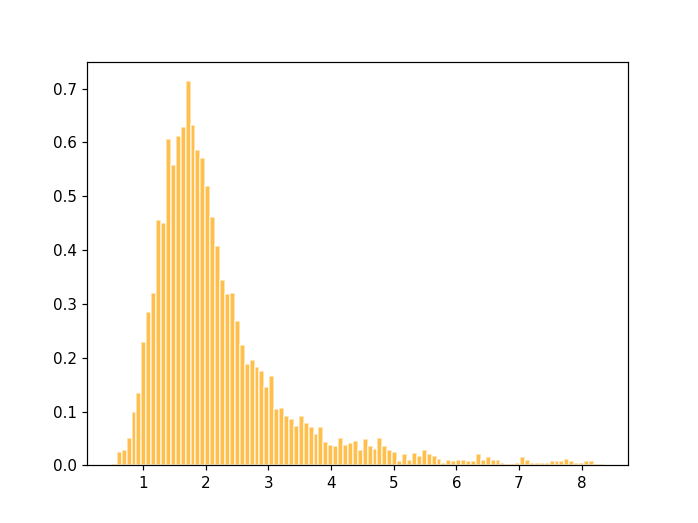

1.1315707943012558


In [79]:
median = np.percentile(z,50)
low_lim = np.percentile(z,5)
high_lim = np.percentile(z,95)
print(median,low_lim,high_lim)
plt.hist(z,bins=100,color='orange',edgecolor='w',density=True,alpha=0.7)
print(np.std(z, ddof=1))
plt.savefig(str(name)+'_z_dist.png')